# NYC Healthcare Access Equity Analysis — Master Dataset Build

## Objective
Build a census tract-level master dataset combining:
1. CDC PLACES health outcomes (2018-2022) for NYC census tracts
2. County-level socioeconomic data (income, insurance) from ACS
3. Healthcare facility density by county from NY State DOH

## Result
Each row = one NYC census tract in one year, with health outcomes and county-level socioeconomic/facility data attached.

In [1]:
# Import libraries
import pandas as pd
import numpy as np

print("Libraries loaded")

Libraries loaded


In [7]:
# Step 2: Load and combine all PLACES files for NYC
nyc_fips = [36005, 36047, 36061, 36081, 36085]
key_measures = ['Diabetes', 'Obesity', 'Depression', 'Stroke']

all_years = []

files = {
    'PLACES_2020_census_tract.csv': 'PLACES 2020',
    'PLACES_2021_census_tract.csv': 'PLACES 2021',
    'PLACES_2022_census_tract.csv': 'PLACES 2022',
    'PLACES_2023_census_tract.csv': 'PLACES 2023',
    'PLACES_2024_census_tract.csv': 'PLACES 2024'
}

for filename, label in files.items():
    filepath = f'/Users/jessduong/Documents/CF/Achievement 6/02 data/Original Data/{filename}'
    df = pd.read_csv(filepath)
    
    # Filter to NYC + key measures
    df_nyc = df[(df['CountyFIPS'].isin(nyc_fips)) & (df['Short_Question_Text'].isin(key_measures))]
    all_years.append(df_nyc)
    print(f"{label}: {len(df_nyc)} rows, Years: {df_nyc['Year'].unique()}")

# Combine all years
places_all = pd.concat(all_years, ignore_index=True)
print(f"\nTotal combined rows: {len(places_all)}")
print(f"Years covered: {sorted(places_all['Year'].unique())}")
print(f"Unique census tracts: {places_all['LocationName'].nunique()}")

PLACES 2020: 6351 rows, Years: [2018]
PLACES 2021: 8468 rows, Years: [2019]
PLACES 2022: 8468 rows, Years: [2020]
PLACES 2023: 8468 rows, Years: [2021]
PLACES 2024: 8924 rows, Years: [2022]

Total combined rows: 40679
Years covered: [np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022)]
Unique census tracts: 2368


In [8]:
# Pivot - one row per census tract per year
# Keep only the columns needed
places_slim = places_all[['Year', 'CountyName', 'CountyFIPS', 'LocationName', 
                           'Short_Question_Text', 'Data_Value', 'TotalPopulation',
                           'Geolocation']].copy()

# Pivot health measures into columns
places_pivot = places_slim.pivot_table(
    index=['Year', 'CountyName', 'CountyFIPS', 'LocationName', 'TotalPopulation', 'Geolocation'],
    columns='Short_Question_Text',
    values='Data_Value'
).reset_index()

# Clean column names
places_pivot.columns.name = None
places_pivot = places_pivot.rename(columns={
    'Diabetes': 'diabetes_pct',
    'Obesity': 'obesity_pct',
    'Depression': 'depression_pct',
    'Stroke': 'stroke_pct',
    'LocationName': 'census_tract',
    'CountyName': 'county'
})

print(f"Rows: {len(places_pivot)}")
print(f"Columns: {places_pivot.columns.tolist()}")
print(f"\nFirst 3 rows:")
print(places_pivot.head(3))

Rows: 10699
Columns: ['Year', 'county', 'CountyFIPS', 'census_tract', 'TotalPopulation', 'Geolocation', 'depression_pct', 'diabetes_pct', 'obesity_pct', 'stroke_pct']

First 3 rows:
   Year county  CountyFIPS  census_tract TotalPopulation  \
0  2018  Bronx       36005   36005000100          11,091   
1  2018  Bronx       36005   36005000200           4,334   
2  2018  Bronx       36005   36005000400           5,503   

                        Geolocation  depression_pct  diabetes_pct  \
0   POINT (-73.88265696 40.7911001)             NaN          10.6   
1  POINT (-73.85899403 40.81064964)             NaN          14.0   
2  POINT (-73.85244756 40.81075834)             NaN          11.5   

   obesity_pct  stroke_pct  
0         33.2         2.8  
1         29.4         3.2  
2         28.2         2.5  


In [9]:
# Attach county-level income, insurance, and facility data

# County-level data from our existing master
county_data = {
    'Bronx':    {'median_income': 48676, 'pct_uninsured': 7.1, 'facility_count': 440, 'pct_age_65plus': 14.5},
    'Kings':    {'median_income': 80263, 'pct_uninsured': 5.6, 'facility_count': 676, 'pct_age_65plus': 15.5},
    'New York': {'median_income': 103931, 'pct_uninsured': 4.0, 'facility_count': 453, 'pct_age_65plus': 17.1},
    'Queens':   {'median_income': 86136, 'pct_uninsured': 7.4, 'facility_count': 449, 'pct_age_65plus': 16.8},
    'Richmond': {'median_income': 98333, 'pct_uninsured': 4.4, 'facility_count': 108, 'pct_age_65plus': 17.0}
}

county_df = pd.DataFrame(county_data).T
county_df.index.name = 'county'
county_df = county_df.reset_index()

# Merge onto master
master = places_pivot.merge(county_df, on='county', how='left')

# Calculate facility density (per 10,000 residents) using census tract population
# First clean TotalPopulation (has commas)
master['tract_population'] = master['TotalPopulation'].str.replace(',', '').astype(float)

print(f"Master dataset rows: {len(master)}")
print(f"Columns: {master.columns.tolist()}")
print(f"\nSample row:")
print(master.iloc[0])

Master dataset rows: 10699
Columns: ['Year', 'county', 'CountyFIPS', 'census_tract', 'TotalPopulation', 'Geolocation', 'depression_pct', 'diabetes_pct', 'obesity_pct', 'stroke_pct', 'median_income', 'pct_uninsured', 'facility_count', 'pct_age_65plus', 'tract_population']

Sample row:
Year                                           2018
county                                        Bronx
CountyFIPS                                    36005
census_tract                            36005000100
TotalPopulation                              11,091
Geolocation         POINT (-73.88265696 40.7911001)
depression_pct                                  NaN
diabetes_pct                                   10.6
obesity_pct                                    33.2
stroke_pct                                      2.8
median_income                               48676.0
pct_uninsured                                   7.1
facility_count                                440.0
pct_age_65plus                         

In [10]:
# Extract latitude/longitude and clean up

# Parse lat/lon from Geolocation (format: "POINT (-73.88 40.79)")
master['longitude'] = master['Geolocation'].str.extract(r'POINT \(([-\d.]+)').astype(float)
master['latitude'] = master['Geolocation'].str.extract(r'([\d.]+)\)').astype(float)

# Drop columns we no longer need
master = master.drop(columns=['TotalPopulation', 'Geolocation', 'CountyFIPS'])

# Reorder columns logically
master = master[['Year', 'census_tract', 'county', 'latitude', 'longitude', 'tract_population',
                  'diabetes_pct', 'obesity_pct', 'depression_pct', 'stroke_pct',
                  'median_income', 'pct_uninsured', 'pct_age_65plus', 'facility_count']]

print(f"Final master: {len(master)} rows x {len(master.columns)} columns")
print(f"\nColumns: {master.columns.tolist()}")
print(f"\nMissing values:")
print(master.isnull().sum())
print(f"\nData types:")
print(master.dtypes)

Final master: 10699 rows x 14 columns

Columns: ['Year', 'census_tract', 'county', 'latitude', 'longitude', 'tract_population', 'diabetes_pct', 'obesity_pct', 'depression_pct', 'stroke_pct', 'median_income', 'pct_uninsured', 'pct_age_65plus', 'facility_count']

Missing values:
Year                   0
census_tract           0
county                 0
latitude               0
longitude              0
tract_population       0
diabetes_pct           0
obesity_pct            0
depression_pct      2117
stroke_pct             0
median_income          0
pct_uninsured          0
pct_age_65plus         0
facility_count         0
dtype: int64

Data types:
Year                  int64
census_tract          int64
county               object
latitude            float64
longitude           float64
tract_population    float64
diabetes_pct        float64
obesity_pct         float64
depression_pct      float64
stroke_pct          float64
median_income       float64
pct_uninsured       float64
pct_age_65

In [11]:
# Save the master dataset
master.to_csv('/Users/jessduong/Documents/CF/Achievement 6/02 data/Prepared Data/nyc_health_master.csv', index=False)

print("Master dataset saved!")
print(f"\nDataset summary:")
print(f"  Rows: {len(master)}")
print(f"  Columns: {len(master.columns)}")
print(f"  Years: {sorted(master['Year'].unique())}")
print(f"  Census tracts: {master['census_tract'].nunique()}")
print(f"  Counties: {master['county'].unique().tolist()}")
print(f"\nContinuous variables: diabetes_pct, obesity_pct, depression_pct, stroke_pct, median_income, pct_uninsured, pct_age_65plus, tract_population, latitude, longitude")
print(f"Categorical variables: county, Year, census_tract")
print(f"\nHead:")
print(master.head())

Master dataset saved!

Dataset summary:
  Rows: 10699
  Columns: 14
  Years: [np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022)]
  Census tracts: 2368
  Counties: ['Bronx', 'Kings', 'New York', 'Queens', 'Richmond']

Continuous variables: diabetes_pct, obesity_pct, depression_pct, stroke_pct, median_income, pct_uninsured, pct_age_65plus, tract_population, latitude, longitude
Categorical variables: county, Year, census_tract

Head:
   Year  census_tract county   latitude  longitude  tract_population  \
0  2018   36005000100  Bronx  40.791100 -73.882657           11091.0   
1  2018   36005000200  Bronx  40.810650 -73.858994            4334.0   
2  2018   36005000400  Bronx  40.810758 -73.852448            5503.0   
3  2018   36005001600  Bronx  40.818855 -73.858079            5643.0   
4  2018   36005001900  Bronx  40.802985 -73.914490            1917.0   

   diabetes_pct  obesity_pct  depression_pct  stroke_pct  median_income  \
0          10.6         33.2

## Summary

### What We Built
This notebook creates the master dataset for the NYC Healthcare Access Equity Analysis project. The dataset contains 10,699 rows representing 2,368 unique census tracts across NYC's five boroughs (Bronx, Kings, New York, Queens, Richmond) over 5 years (2018-2022).

### Data Sources Combined
- CDC PLACES (2020-2024 releases): Census tract-level health outcomes (diabetes, obesity, depression, stroke) covering data years 2018-2022
- ACS 2024 5-Year Estimates: County-level median income, uninsured rates, and age demographics
- NY State Health Facilities Database: Healthcare facility counts by county

### Variables
- Continuous: diabetes_pct, obesity_pct, depression_pct, stroke_pct, median_income, pct_uninsured, pct_age_65plus, tract_population, latitude, longitude
- Categorical: county, Year, census_tract

### Known Limitations
- Depression data is unavailable for 2018 (2,117 missing values) because the CDC did not include this measure in the earliest PLACES release for NYC tracts.
- Socioeconomic variables (median_income, pct_uninsured, pct_age_65plus) and facility_count are at the county level, meaning all census tracts within the same county share the same values. This limits our ability to detect within-county socioeconomic variation. Census tract-level ACS data could be sourced in future iterations to improve granularity.

### Output
Saved as: nyc_health_master.csv (10,699 rows x 14 columns)

# Exercise 6.2: Exploratory Visual Analysis

## Objective
Explore relationships between health outcomes and socioeconomic variables across NYC census tracts using correlation heatmaps, scatterplots, pair plots, and categorical plots.

In [13]:
# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
# Load the master dataset
df = pd.read_csv('/Users/jessduong/Documents/CF/Achievement 6/02 data/Prepared Data/nyc_health_master.csv')

In [15]:
# Filter to 2022 (most recent year) for cross-sectional analysis
df_2022 = df[df['Year'] == 2022].copy()

print(f"Full dataset: {len(df)} rows")
print(f"2022 only: {len(df_2022)} rows")
print(f"\nDescriptive stats for 2022:")
print(df_2022.describe().round(2))

Full dataset: 10699 rows
2022 only: 2231 rows

Descriptive stats for 2022:
         Year  census_tract  latitude  longitude  tract_population  \
count  2231.0  2.231000e+03   2231.00    2231.00           2231.00   
mean   2022.0  3.605488e+10     40.72     -73.92           3945.95   
std       0.0  2.592787e+07      0.08       0.09           1939.29   
min    2022.0  3.600500e+10     40.50     -74.24             69.00   
25%    2022.0  3.604703e+10     40.65     -73.97           2500.50   
50%    2022.0  3.604712e+10     40.71     -73.92           3679.00   
75%    2022.0  3.608103e+10     40.77     -73.86           5040.00   
max    2022.0  3.608503e+10     40.91     -73.70          17222.00   

       diabetes_pct  obesity_pct  depression_pct  stroke_pct  median_income  \
count       2231.00      2231.00         2231.00     2231.00        2231.00   
mean          11.77        27.31           17.36        3.42       81347.68   
std            3.74         6.98            2.62        1

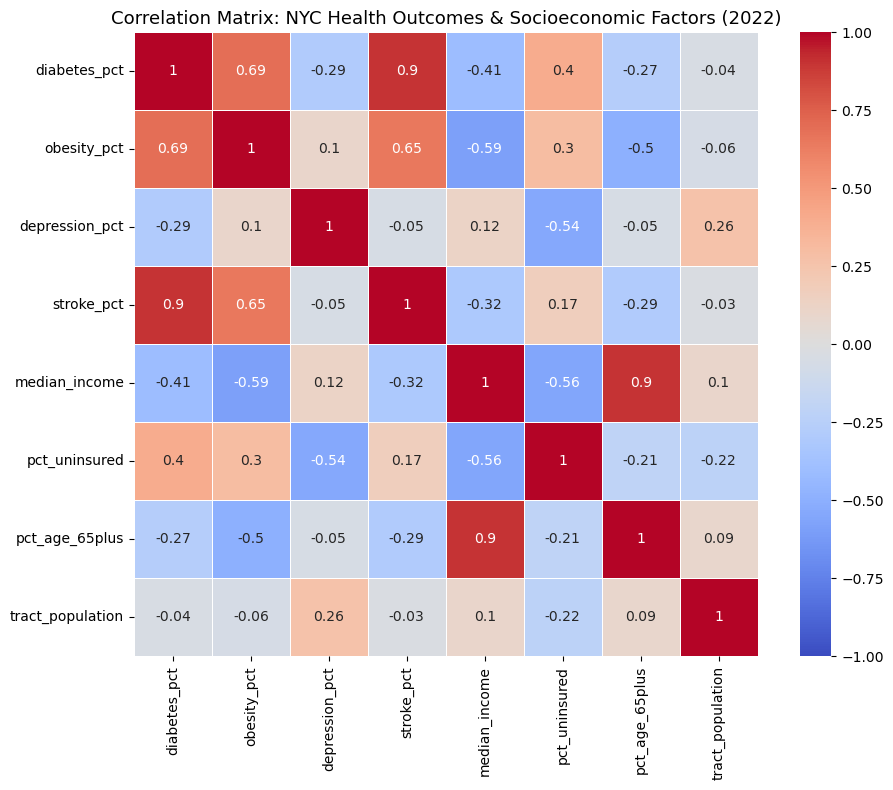


Correlation matrix:
                  diabetes_pct  obesity_pct  depression_pct  stroke_pct  \
diabetes_pct              1.00         0.69           -0.29        0.90   
obesity_pct               0.69         1.00            0.10        0.65   
depression_pct           -0.29         0.10            1.00       -0.05   
stroke_pct                0.90         0.65           -0.05        1.00   
median_income            -0.41        -0.59            0.12       -0.32   
pct_uninsured             0.40         0.30           -0.54        0.17   
pct_age_65plus           -0.27        -0.50           -0.05       -0.29   
tract_population         -0.04        -0.06            0.26       -0.03   

                  median_income  pct_uninsured  pct_age_65plus  \
diabetes_pct              -0.41           0.40           -0.27   
obesity_pct               -0.59           0.30           -0.50   
depression_pct             0.12          -0.54           -0.05   
stroke_pct                -0.32        

In [16]:
# Correlation Matrix Heatmap
# Select continuous variables for correlation
corr_vars = ['diabetes_pct', 'obesity_pct', 'depression_pct', 'stroke_pct',
             'median_income', 'pct_uninsured', 'pct_age_65plus', 'tract_population']

corr_matrix = df_2022[corr_vars].corr().round(2)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1,
            square=True, linewidths=0.5)
plt.title('Correlation Matrix: NYC Health Outcomes & Socioeconomic Factors (2022)', fontsize=13)
plt.tight_layout()

# Save image
plt.savefig('/Users/jessduong/Documents/CF/Achievement 6/04 analysis/visualizations/correlation_heatmap.png', dpi=150)
plt.show()

print("\nCorrelation matrix:")
print(corr_matrix)

### Correlation Heatmap Interpretation

The heatmap reveals several key relationships across NYC census tracts in 2022:

**Strong positive correlations:** Diabetes and stroke show the strongest correlation (0.90), followed by diabetes and obesity (0.69) and obesity and stroke (0.65). Census tracts with high rates of one chronic condition tend to have high rates of the others.

**Income and health outcomes:** Median income is negatively correlated with obesity (-0.59), diabetes (-0.41), and stroke (-0.32), meaning higher-income areas tend to have lower chronic disease rates. Income also has a strong positive correlation with pct_age_65plus (0.90), suggesting wealthier boroughs have older populations.

**Uninsured rate:** Percent uninsured is negatively correlated with depression (-0.54) and median income (-0.56). It is positively correlated with diabetes (0.40) and obesity (0.30), suggesting areas with less insurance coverage have higher rates of these conditions.

**Depression stands apart:** Depression shows weak or negative correlations with the other health outcomes (diabetes: -0.29, stroke: -0.05, obesity: 0.10). It is also negatively correlated with pct_uninsured (-0.54), meaning areas with higher insurance coverage actually have higher depression rates. This suggests depression is driven by different factors than other chronic conditions.

**Tract population:** Population size shows little to no meaningful correlation with any health outcome, indicating that tract density alone does not predict health.

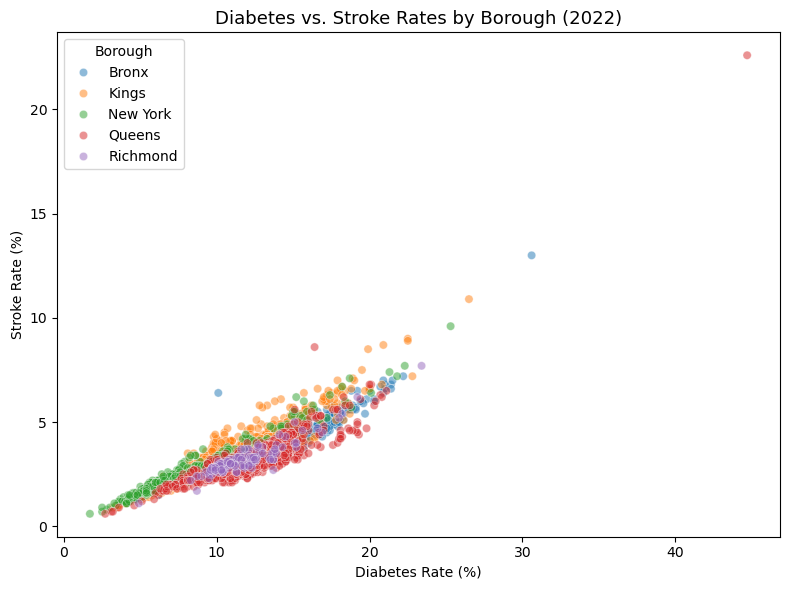

In [17]:
# Scatterplot - strongest correlation (diabetes vs stroke: 0.90)
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_2022, x='diabetes_pct', y='stroke_pct', hue='county', alpha=0.5)
plt.title('Diabetes vs. Stroke Rates by Borough (2022)', fontsize=13)
plt.xlabel('Diabetes Rate (%)')
plt.ylabel('Stroke Rate (%)')
plt.legend(title='Borough')
plt.tight_layout()

# Save Fig
plt.savefig('/Users/jessduong/Documents/CF/Achievement 6/04 analysis/visualizations/scatter_diabetes_stroke.png', dpi=150)
plt.show()

### Scatterplot Interpretation: Diabetes vs. Stroke (r = 0.90)

The scatterplot confirms a strong positive linear relationship between diabetes and stroke rates across NYC census tracts. As diabetes rates increase, stroke rates increase proportionally.

Borough patterns are visible: New York (Manhattan) census tracts cluster in the lower-left with the lowest rates of both conditions, while Bronx and Kings (Brooklyn) tracts extend into the upper-right with the highest rates. There is one notable outlier in Queens with a diabetes rate above 40% and stroke above 20%, which may warrant further investigation.

This strong correlation suggests that census tracts struggling with diabetes are also disproportionately affected by stroke, pointing to shared underlying risk factors such as income, diet, and healthcare access.

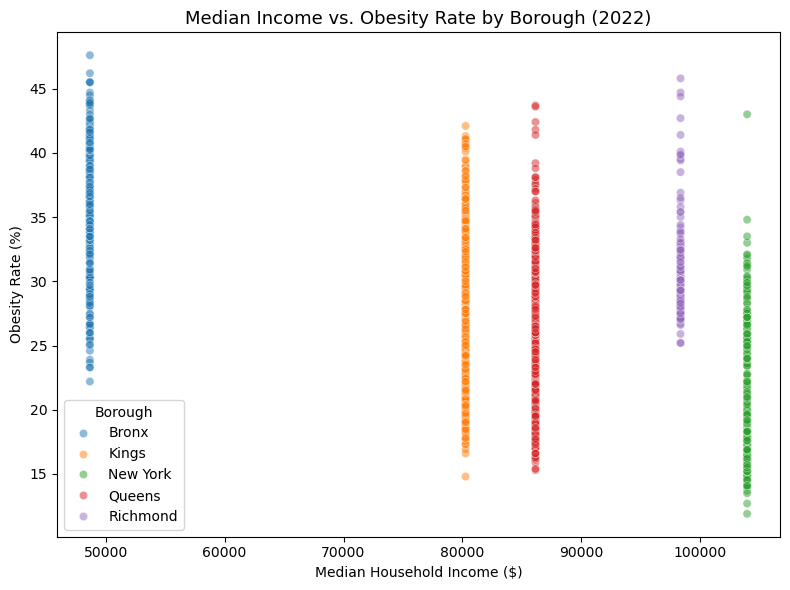

In [18]:
# Scatterplot 2 - income vs obesity
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_2022, x='median_income', y='obesity_pct', hue='county', alpha=0.5)
plt.title('Median Income vs. Obesity Rate by Borough (2022)', fontsize=13)
plt.xlabel('Median Household Income ($)')
plt.ylabel('Obesity Rate (%)')
plt.legend(title='Borough')
plt.tight_layout()

# Save image
plt.savefig('/Users/jessduong/Documents/CF/Achievement 6/04 analysis/visualizations/scatter_income_obesity.png', dpi=150)
plt.show()

### Scatterplot Interpretation: Median Income vs. Obesity (r = -0.59)

The overall negative trend is visible: the Bronx (lowest income at ~$49K) has the highest concentration of obesity rates, while New York/Manhattan (highest income at ~104K) generally has lower obesity rates.  This supports the relationship between income and health outcomes.

However, this plot also reveals a limitation of our dataset: because median income is measured at the county level, the points form vertical columns rather than a continuous scatter. Each column represents one borough's census tracts, all sharing the same income value. This means the correlation is driven by between-borough differences, not within-borough variation. Census tract-level income data would provide a more granular picture.

Notably, there is wide variation in obesity rates within each borough. For example, Queens ranges from about 15% to 44%, showing that even within a single income group, other factors drive significant health outcome differences at the neighborhood level.

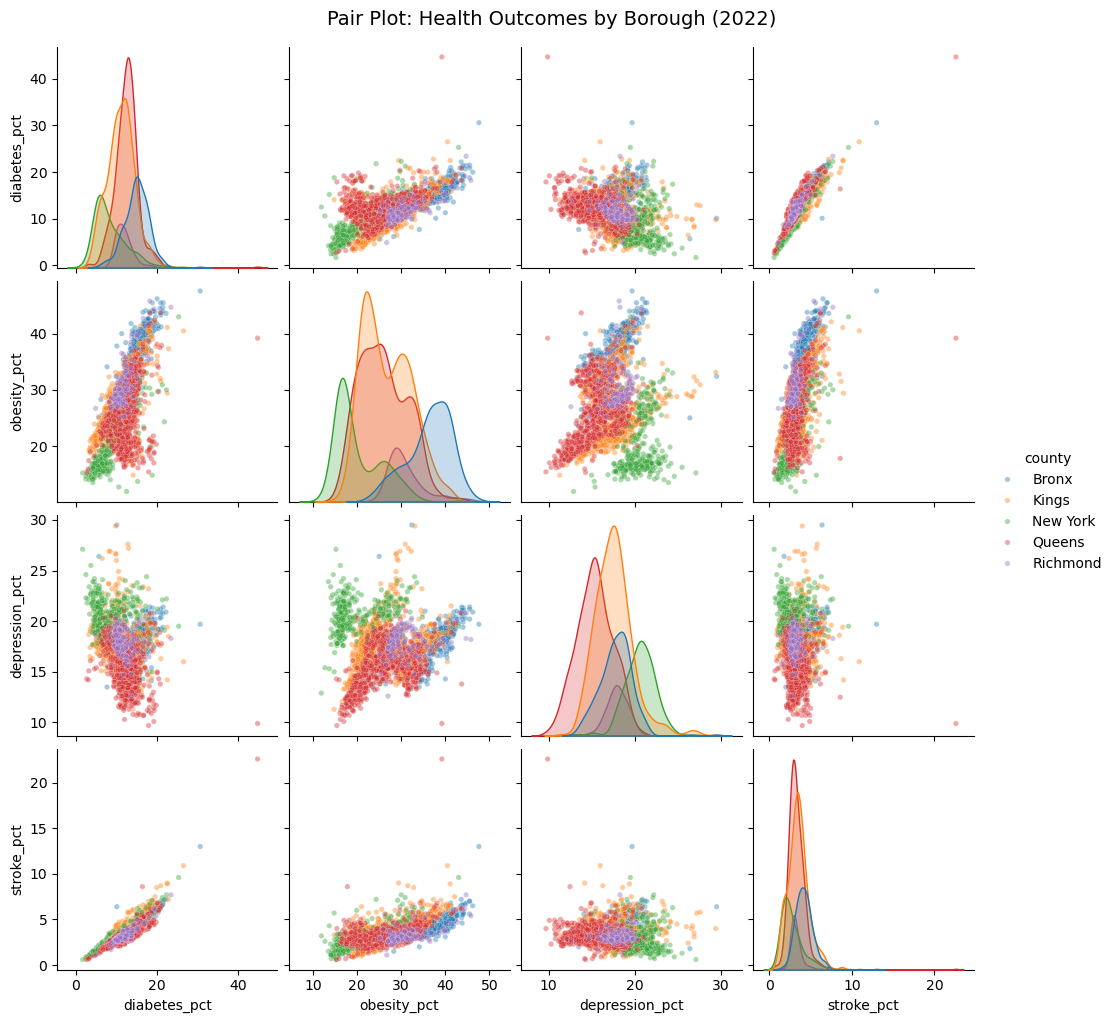

In [20]:
# Pair Plot - health outcomes only (tract-level data)
pair_vars = ['diabetes_pct', 'obesity_pct', 'depression_pct', 'stroke_pct']
sns.pairplot(df_2022[pair_vars + ['county']], hue='county', diag_kind='kde', 
             plot_kws={'alpha': 0.4, 's': 15}, height=2.5)
plt.suptitle('Pair Plot: Health Outcomes by Borough (2022)', y=1.02, fontsize=14)

# Save image
plt.savefig('/Users/jessduong/Documents/CF/Achievement 6/04 analysis/visualizations/pair_plot.png', dpi=150, bbox_inches='tight')
plt.show()

### Pair Plot Interpretation

**Distributions (diagonal):** The KDE curves show that each borough has a distinct distribution pattern. New York (Manhattan) consistently sits on the lower end of diabetes, obesity, and stroke, while Bronx tends toward the higher end. Depression distributions overlap more across boroughs, confirming it behaves differently from the other health outcomes.

**Variables to explore further:**
- Diabetes and stroke: Very tight linear relationship (r = 0.90) visible across all boroughs, suggesting shared risk factors worth investigating in regression analysis.
- Obesity and diabetes: Strong positive relationship (r = 0.69) with clear borough clustering, indicating geographic patterns in these co-occurring conditions.
- Depression vs. other outcomes: Depression shows a different pattern — it does not follow the same positive relationship with diabetes, obesity, or stroke. This warrants further investigation into what drives depression rates independently.

**Borough separation:** The Bronx and New York (Manhattan) are the most clearly separated across all health outcomes, representing opposite ends of the health outcome spectrum. Kings, Queens, and Richmond overlap significantly in the middle.

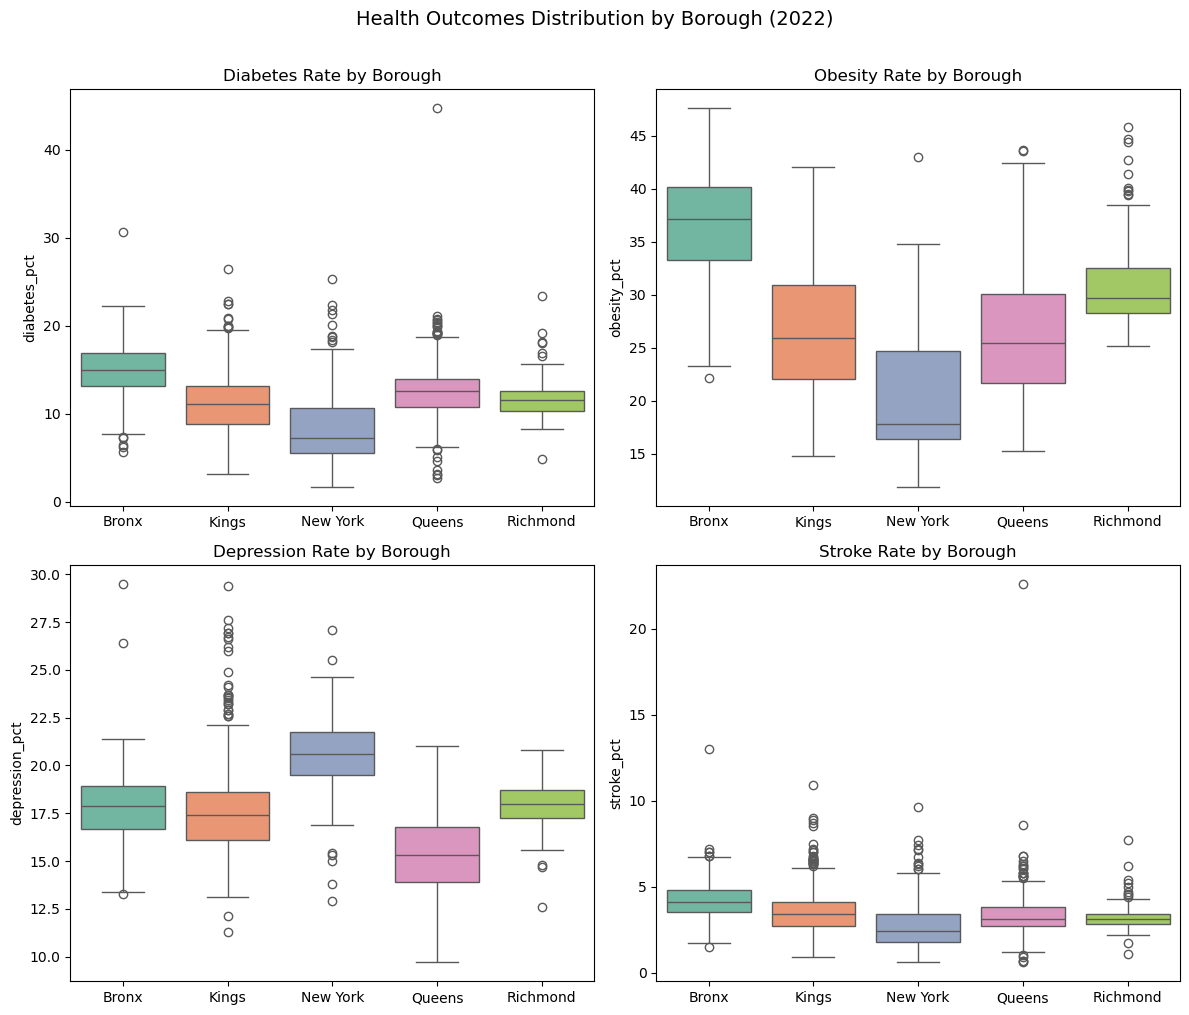

In [23]:
# Categorical Plot - health outcomes by borough
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

sns.boxplot(data=df_2022, x='county', y='diabetes_pct', hue='county', ax=axes[0,0], palette='Set2', legend=False)
axes[0,0].set_title('Diabetes Rate by Borough')
axes[0,0].set_xlabel('')

sns.boxplot(data=df_2022, x='county', y='obesity_pct', hue='county', ax=axes[0,1], palette='Set2', legend=False)
axes[0,1].set_title('Obesity Rate by Borough')
axes[0,1].set_xlabel('')

sns.boxplot(data=df_2022, x='county', y='depression_pct', hue='county', ax=axes[1,0], palette='Set2', legend=False)
axes[1,0].set_title('Depression Rate by Borough')
axes[1,0].set_xlabel('')

sns.boxplot(data=df_2022, x='county', y='stroke_pct', hue='county', ax=axes[1,1], palette='Set2', legend=False)
axes[1,1].set_title('Stroke Rate by Borough')
axes[1,1].set_xlabel('')

plt.suptitle('Health Outcomes Distribution by Borough (2022)', fontsize=14, y=1.01)
plt.tight_layout()

# Save image
plt.savefig('/Users/jessduong/Documents/CF/Achievement 6/04 analysis/visualizations/boxplots_by_borough.png', dpi=150, bbox_inches='tight')
plt.show()

### Categorical Plot Interpretation: Box Plots by Borough

**Diabetes:** The Bronx has the highest median diabetes rate (~15%) with a wide spread, while New York (Manhattan) has the lowest (~8%). Queens shows the most outliers on the high end, with one tract above 40%.

**Obesity:** The Bronx again leads with a median around 36%, while New York (Manhattan) has the lowest median around 24%. Richmond (Staten Island) has a wide range extending to 45%+, suggesting significant within-borough variation.

**Depression:** This is where the pattern reverses. New York (Manhattan) has the highest depression rates (~21% median), while Queens has the lowest (~15%). This confirms that depression behaves differently from the other health conditions and is not driven by the same income-related factors.

**Stroke:** The Bronx has the highest median stroke rate (~5%) with New York (Manhattan) the lowest (~3%). All boroughs show outliers, with one Queens tract above 20%.

**Key takeaway:** For diabetes, obesity, and stroke, the borough ranking is consistent — Bronx worst, Manhattan best. Depression breaks this pattern entirely, with Manhattan showing the highest rates despite having the highest income. This reinforces the need to investigate depression separately from the other chronic conditions.

## Revisiting Research Questions

Based on the exploratory analysis, here are updated answers to the original research questions:

1. **Which NYC neighborhoods have the lowest healthcare facility density per capita?** Queens has the lowest facility density based on county-level data. Census tract-level facility analysis is needed for neighborhood-level answers.

2. **Do neighborhoods with higher rates of chronic disease have fewer healthcare facilities?** Not necessarily. The Bronx has the highest facility density AND the worst health outcomes, suggesting that facility access alone does not drive better health.

3. **How does median household income correlate with healthcare access metrics?** Income shows strong negative correlations with diabetes (-0.41), obesity (-0.59), and stroke (-0.32). Higher income boroughs consistently have better health outcomes for these conditions.

4. **New question: Why does depression behave differently?** Depression has the highest rates in Manhattan (highest income borough) and is negatively correlated with the other chronic conditions. What urban factors drive this pattern?

5. **New question: What are the within-borough disparities?** Box plots show wide variation within each borough, particularly in Queens and Richmond. Neighborhood-level analysis could reveal pockets of need hidden by borough averages.

## Hypotheses

1. **Income predicts chronic disease:** Census tracts in lower-income boroughs will have significantly higher rates of diabetes, obesity, and stroke than those in higher-income boroughs.

2. **Facility density does not predict health outcomes:** Higher healthcare facility density will not correlate with better health outcomes at the borough level, as demonstrated by the Bronx paradox.

3. **Depression is driven by different factors:** Depression rates will not follow the same income-health pattern as diabetes, obesity, and stroke, suggesting non-economic urban stressors play a larger role.